In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
import glob
import pickle
import urllib
import datetime
import scipy
from scipy import stats
from pylab import *
from matplotlib.colors import ListedColormap
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import ee; ee.Initialize()

In [18]:
def getFlowTemp(site,start,stop):
    url = 'https://waterdata.usgs.gov/nwis/uv?cb_00010=on&cb_00060=on&cb_00065=on&format=rdb&site_no='+site+'&period=&begin_date='+start+'&end_date='+stop
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site', 'datetime', 'q', 'a']
    df.index = pd.to_datetime(df.datetime)
    df = df[['q']]
    df.q = df.q.astype(float, errors='ignore')
    df.to_csv('../data/' + site + '.csv')
    return df

def getFlow(site,start,stop):
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start+'&end_date='+stop
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site', 'datetime', 'q', 'a']
    df.index = pd.to_datetime(df.datetime)
    df = df[['q']]
    df.q = df.q.astype(float, errors='ignore')
    df.to_csv('../data/' + site + '.csv')
    return df

def pull_prism(lat,lon,startyear,stopyear):
    rvws = ee.Geometry.Point([lon, lat])
    def extract(image):
        val = image.reduceRegion(ee.Reducer.mean(), rvws)
        ft = ee.Feature(rvws, {'ppt':val.get('ppt'), 'date':image.get('system:index')})
        return ft
    dates, vals = [], []
    for year in range(startyear, stopyear+1):
        startdate = str(year-1) + '-09-30'
        enddate = str(year) + '-09-30'
        prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81d').select('ppt').filterDate(startdate, enddate)
        rain = prism.map(extract).getInfo()
        for item in rain['features']:
            props = item['properties']
            dates.append(pd.to_datetime(props['date']))
            vals.append(props['ppt'])
    prism = pd.DataFrame(vals, index=dates, columns=['ppt'])
    prism = prism.sort_index()
    return prism


In [19]:
lat,lon = 39.719368, -123.610090
rainfall = pull_prism(lat,lon,2000,2019)
rainfall.to_csv('../data/elder_rainfall.csv')

In [21]:
rainfall = pd.read_csv('../data/elder_rainfall.csv', index_col=0,parse_dates=True)
elder = getFlow('11475560','2000-01-01','2019-12-30')
elder = elder[['q']]*2.447e+12 # convert to mm^3/day
area = 16.8 * 1e+12 # convert to mm/day
elder = elder/area


# get water year
elder['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in elder.index]
rainfall['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in rainfall.index]
elder = elder.loc['2000-10-01':'2018-12-31']
rainfall = rainfall.loc['2000-10-01':'2018-12-31']
elder.to_csv('../data/elder_runoff.csv')

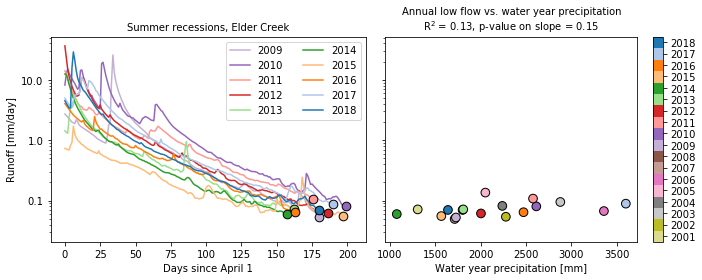

In [8]:
years = elder.index.year.unique()
wyrain = []
lowflow = []
yearplot = []
lowflowdate = []
for year in years[1:]:
    wystart = str(year-1) + '-10-01'
    wyend = str(year) + '-9-1'
    sd = str(year) + '-05-01'
    ed = str(year) + '-12-01'
    wyrain.append(rainfall.ppt.loc[wystart:wyend].sum())
    lowflow.append(elder.q.loc[sd:ed].min())
    lowflowdate.append(elder.q.loc[sd:ed].idxmin())
    yearplot.append(year)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(wyrain),np.array(lowflow))
f,axs = plt.subplots(1,2,figsize=(10,4), sharey=True)
cmap = ListedColormap(sns.color_palette('tab20',len(yearplot)).as_hex()).reversed()
pal = np.flip(sns.color_palette('tab20',len(yearplot)).as_hex(), axis=0)
ax = axs[1]
sp = ax.scatter(wyrain, lowflow,c=yearplot,cmap=cmap,s=75,edgecolors='k')
bounds = np.array([i for i in yearplot + [yearplot[-1]+1]])-0.5
plt.colorbar(sp, ticks=[i for i in yearplot if i%1==0], boundaries=bounds)
titlestr = 'Annual low flow vs. water year precipitation'
titlestr += '\nR$^2$ = %.2f, p-value on slope = %.2f'%(r_value**2, p_value)
ax.set_title(titlestr, fontsize=10)
ax.set_xlabel('Water year precipitation [mm]')
ax.set_yscale('log')
ax = axs[0]
tp = range(2009,2019)
labels = []
handles = []
for i,year in enumerate(years[1:]):
    if year in tp:
        sd = str(year) + '-4-01'
        ed = lowflowdate[i]
        toplot = elder.q.loc[sd:ed]
        x = range(len(toplot))
        h, = ax.plot(x,toplot,c=pal[i])
        handles.append(h)
        labels.append(year)        
        ax.scatter(x[-1],toplot[-1],c=pal[i],s=75,edgecolors='k',zorder=100)
    else:
        continue
ax.legend(labels, fontsize=10,ncol=2)
ax.set_ylabel('Runoff [mm/day]')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_title('Summer recessions, Elder Creek', fontsize=10)
ax.set_xlabel('Days since April 1')
f.tight_layout()
f.savefig('../figures/lowflow_wyprecip.pdf')